# Indlæsning af data og kategorisering (samme som i Gruppering filen)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

# indlæs data: husk at ændre så det passer din filplacering
mappe_sti = r"C:\Users\kftro\OneDrive - Aarhus universitet\Dataprojekt\Analyse"

# Liste over månederne (skal matche filnavnene)
maaneder = ['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']



# INDLÆS ALLE 12 MÅNEDER
alle_dataframes = []

print("Starter indlæsning af hele året...")

for m in maaneder:
    # Konstruer filnavnet: "PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
    filnavn = f"PLC, Product detaljeret, Aarhus, {m}. 2023.xlsx"
    fuld_sti = os.path.join(mappe_sti, filnavn)
    
    if os.path.exists(fuld_sti):
        try:
            # Prøv som Excel
            temp_df = pd.read_excel(fuld_sti, header=2)
        except:
            # Fallback til CSV
            temp_df = pd.read_csv(fuld_sti, header=2, sep=';', encoding='latin1')
            
        # Gem hvilken måned data kommer fra (kan være brugbart senere)
        temp_df['Måned'] = m
        alle_dataframes.append(temp_df)
        print(f"  -> {m} indlæst.")
    else:
        print(f"  -> {m} fil mangler/kunne ikke findes.")

# Saml alt i én stor tabel
if alle_dataframes:
    df_total = pd.concat(alle_dataframes, ignore_index=True)
    print(f"\nSucces! Har samlet data for {len(df_total)} kasserede artikler.")
else:
    print("Fejl: Ingen data fundet.")
    exit()


Starter indlæsning af hele året...
  -> Jan indlæst.
  -> Feb indlæst.
  -> Mar indlæst.
  -> Apr indlæst.
  -> Maj indlæst.
  -> Jun indlæst.
  -> Jul indlæst.
  -> Aug indlæst.
  -> Sep indlæst.
  -> Okt indlæst.
  -> Nov indlæst.
  -> Dec indlæst.

Succes! Har samlet data for 248711 kasserede artikler.


In [2]:
def find_kategori(navn):
    if not isinstance(navn, str): return "Ukendt"
    navn_ren = navn.lower().replace(',', '').replace('.', '')
    
    # 1. SPECIALBEKLÆDNING (Skal fanges først!) 
    if 'term' in navn_ren: return 'Termotøj'
    if 'kedeldr' in navn_ren: return 'Kedeldragt'
    if 'overall' in navn_ren: return 'Overalls'
    
    # Flyttet op: Hvis det er kokketøj (kokkejakke/kokkebuks, osv.) fanges det her
    if 'kok' in navn_ren: return 'Kokketøj' 
    
    # 2. UNDERDELE 
    if 'underbuk' in navn_ren: return 'Underbukser'
    if any(x in navn_ren for x in ['ben', 'buks', 'jeans', 'unisexben']): return 'Bukser'
    if 'shorts' in navn_ren: return 'Shorts'
    
    # 3. OVERDELE
    if 'cardigan' in navn_ren: return 'Cardigan'
    if 'sweat' in navn_ren: return 'Sweatshirt'

    if any(x in navn_ren for x in ['t-shirt', 'tshirt']): return 'T-shirt' 

    if 'polo' in navn_ren: return 'Polo'
    if 'hætte' in navn_ren: return 'Hættetrøje'
    if 'skj' in navn_ren: return 'Skjorte'
    if 'bussero' in navn_ren: return 'Busseronne'
    if 'tunika' in navn_ren: return 'Tunika'
    if 'kit' in navn_ren: return 'Kittel'
    if 'vest' in navn_ren: return 'Vest'
    
   
    # Denne linje fanger kun jakker, der IKKE eksempelvis er kokkejakker eller termojakker. 
    if any(x in navn_ren for x in ['jak', 'jk']): return 'Jakke'
    
    if 'fleece' in navn_ren: return 'Fleece'
    if 'kasket' in navn_ren: return 'Kasket'
    
    # 4. KØKKEN & TILBEHØR
    if 'forklæde' in navn_ren or 'smæk' in navn_ren: return 'Forklæde'

    
    # Opsamling
    parts = navn_ren.split()
    if len(parts) > 1:
        return "Andet (" + parts[1].title() + ")"
    return "Andet"

# Violinplots for de N mest populære kategorier

C:\Users\kftro\AppData\Local\Temp\ipykernel_13936\2681509500.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\kftro\AppData\Local\Temp\ipykernel_13936\2681509500.py:32: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


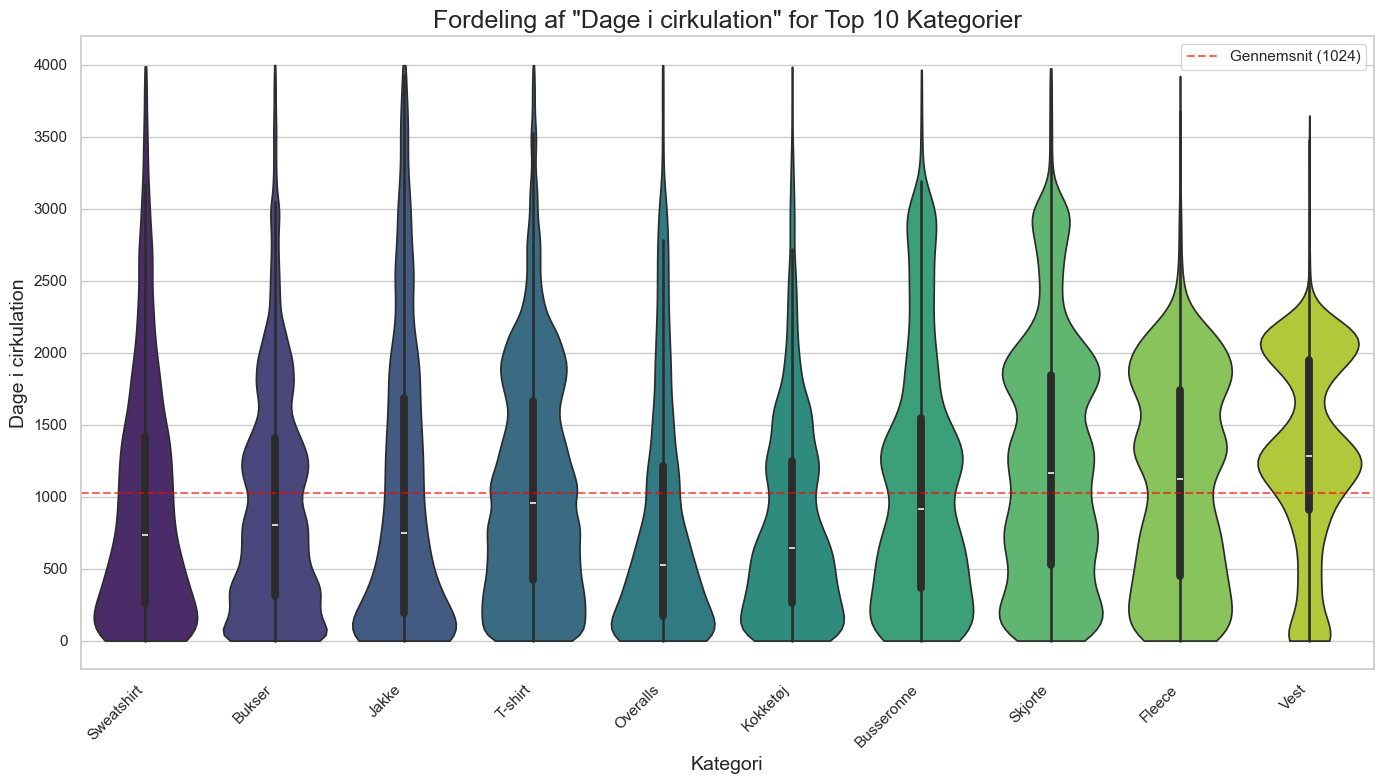

In [ ]:
# Antal kategorier i plottet
N = 10 

# Muligheder: 'Dage i cirkulation'  ELLER  'Total antal vask'
y_akse_navn = 'Dage i cirkulation'

# Forberedelse af data - sørg for at have indlæst df_total inden
if 'Kategori' not in df_total.columns:
    df_total['Kategori'] = df_total['Produkt - Produkt'].apply(find_kategori)

# Sikre at kolonnerne er tal
cols_to_numeric = ['Dage i cirkulation', 'Total antal vask']
for col in cols_to_numeric:
    df_total[col] = pd.to_numeric(df_total[col], errors='coerce')

# Find de N mest populære kategorier
top_kategorier = df_total['Kategori'].value_counts().head(N).index
df_plot = df_total[df_total['Kategori'].isin(top_kategorier)]

# Fjern ekstreme outliers for pænere graf (skal måske tweakes lidt)
if y_akse_navn == 'Dage i cirkulation':
    grænse = 4000 # Fjern alt over ca 11 år
elif y_akse_navn == 'Total antal vask':
    grænse = 300  # Fjern alt over 300 vaske
    
df_plot = df_plot[df_plot[y_akse_navn] < grænse]

# PLOTTET
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.violinplot(
    data=df_plot, 
    x='Kategori', 
    y=y_akse_navn, 
    palette="viridis", 
    cut=0,          # Skærer grafen af ved min/max data
    scale='width'   # Gør alle violiner lige brede for nem sammenligning
)

plt.title(f'Fordeling af "{y_akse_navn}" for Top {N} Kategorier', fontsize=18)
plt.xlabel('Kategori', fontsize=14)
plt.ylabel(y_akse_navn, fontsize=14)
plt.xticks(rotation=45, ha='right')

# Tilføj gennemsnitslinje
snit = df_plot[y_akse_navn].mean()
plt.axhline(snit, color='red', linestyle='--', alpha=0.6, label=f'Gennemsnit ({int(snit)})')
plt.legend()

plt.tight_layout()
plt.show()

# Violionplots over kassationsårsager for en bestemt kategori

C:\Users\kftro\AppData\Local\Temp\ipykernel_13936\3830280619.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\kftro\AppData\Local\Temp\ipykernel_13936\3830280619.py:34: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


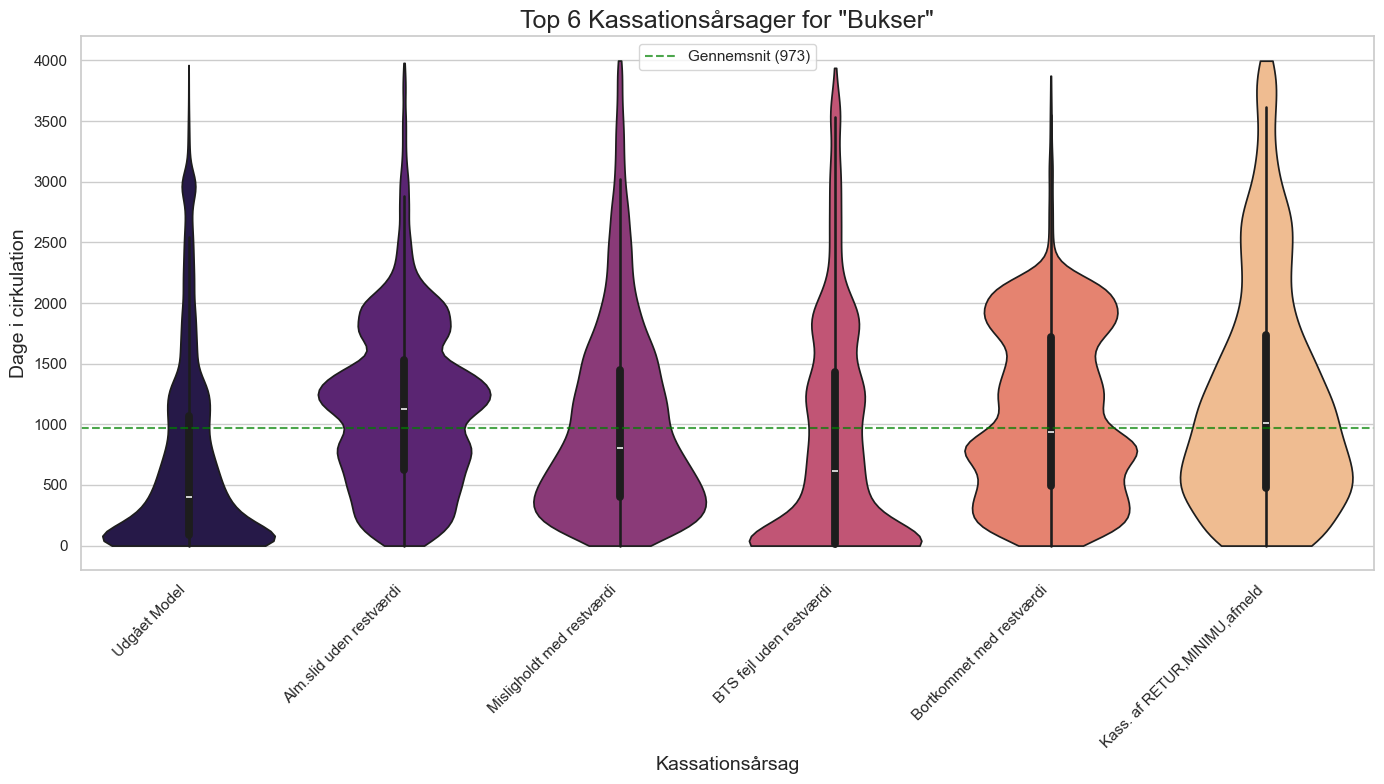

In [9]:
# Indstillinger
valgt_kategori = 'Bukser'      # Kategori ('Skjorte', 'T-shirt', osv.)
N = 6                          # Antal kassationsårsager
y_akse_variabel = 'Dage i cirkulation' # 'Dage i cirkulation' eller 'Total antal vask' på y-aksen



# Dataforberedelse
if 'Kategori' not in df_total.columns:
    df_total['Kategori'] = df_total['Produkt - Produkt'].apply(find_kategori)

# Konverter til tal
df_total[y_akse_variabel] = pd.to_numeric(df_total[y_akse_variabel], errors='coerce')

# Filtrerring:
# Behold kun rækker for den valgte kategori
df_kategori = df_total[df_total['Kategori'] == valgt_kategori]

# Find de top N årsager for NETOP denne kategori
top_årsager = df_kategori['Kassationsårsag (ui)'].value_counts().head(N).index
df_plot = df_kategori[df_kategori['Kassationsårsag (ui)'].isin(top_årsager)]

# Fjern outliers
if y_akse_variabel == 'Dage i cirkulation':
    df_plot = df_plot[df_plot[y_akse_variabel] < 4000]
elif y_akse_variabel == 'Total antal vask':
    df_plot = df_plot[df_plot[y_akse_variabel] < 300]


# Plottet
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.violinplot(
    data=df_plot, 
    x='Kassationsårsag (ui)', 
    y=y_akse_variabel, 
    palette="magma", # 'magma' giver flotte farver
    cut=0, 
    scale='width'
)

plt.title(f'Top {N} Kassationsårsager for "{valgt_kategori}"', fontsize=18)
plt.xlabel('Kassationsårsag', fontsize=14)
plt.ylabel(y_akse_variabel, fontsize=14)
plt.xticks(rotation=45, ha='right')

# Tilføj gennemsnit
snit = df_plot[y_akse_variabel].mean()
plt.axhline(snit, color='green', linestyle='--', alpha=0.7, label=f'Gennemsnit ({int(snit)})')
plt.legend()

plt.tight_layout()
plt.show()